# Drag from Tides

This implementation adds drag from the tidal interactions between a primary body and all other bodies in the simulation, from slowly rotating tides raised on the primary body. The effect assumes all affected particles follow co-planar, circular orbits with respect to the primary's rotational pole.

In all cases, we need to set masses for all the particles that will feel these tidal forces. After that, we can choose to include tides raised on the primary by setting its `R_tides` (physical radius), `luminosity` (in units consistent with G), and `tides_lambda2` (a coefficient that depends on the properties of the primary's convective envelope). Note that the `R_tides` parameter can be independently set from the physical radius stored in `rebound.Particle.r`.

As an example, we'll add the tidal drag on the Earth induced by slowly rotating tidal bulges raised on a post-main sequence Sun near its tip-RGB phase.

In [1]:
import rebound
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun') 
sim.add(m=0.86)        # post-MS Sun
sim.add(m=3.e-6, a=1.) # Earth
sim.move_to_com()
ps = sim.particles

Now we add the effect and have to set the `R_tides`, `luminosity`, and `tides_lambda2` parameters for the Sun.

In [2]:
import reboundx
rebx = reboundx.Extras(sim)
tides = rebx.load_force("tides_drag")
rebx.add_force(tides)
ps[0].params["R_tides"] = 0.78 # in AU
ps[0].params["luminosity"] = 869.5
ps[0].params["tides_lambda2"] = 0.023

The implementation defaults to treating `sim.particles[0]` as the primary, i.e., the dominant source of tidal drag on the other bodies.  You can also set this flag explicitly (if the primary were at a different index):

In [3]:
ps[0].params["tides_primary"] = 0

Similarly, you can optionally specify the primary rotational angular velocity by setting `tides_Omega`, which otherwise defaults to zero.

In [4]:
ps[0].params["tides_Omega"] = 0.

We'll integrate for 70,000 years and store the Earth's semi-major axis.

In [5]:
import numpy as np
tmax = 7e4
Nout=1000

pa = np.zeros(Nout)
times = np.linspace(0,tmax,Nout)
# to plot physical radius of the Sun
R0 = 0*times + ps[0].params["R_tides"]

In [6]:
for i, time in enumerate(times):
    sim.integrate(time)
    pa[i] = ps[1].a

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


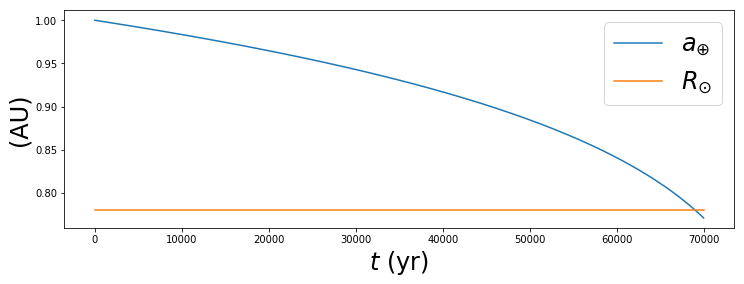

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, pa, label='$a_{\oplus}$')
ax.plot(times, R0, label='$R_{\odot}$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('(AU)', fontsize=24)
ax.legend(fontsize=24, loc='best')

In [47]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun') 
sim.add(m=0.86, r = 0.78)        # post-MS Sun
sim.add(m=3.e-6, a=1., e=0.05) # Earth
sim.move_to_com()
sim.collision = "direct"
ps = sim.particles

rebx = reboundx.Extras(sim)
tides = rebx.load_force("tides_precession")
rebx.add_force(tides)
ps[0].params["tctl_k1"] = 0.023 # in AU
lum = 869.5
tf = (ps[0].m*ps[0].r**2/lum)**(1./3.)
ps[0].params["tctl_tau"] = 2*ps[0].r**3/sim.G/ps[0].m/tf
ps[0].params["Omega"] = 0.

tmax = 7e4
Nout=1000


q = (ps[1].m/ps[0].m)
T = ps[0].r**3/sim.G/ps[0].m/ps[0].params["tctl_tau"]
taua = T/6/ps[0].params["tctl_k1"]/q/(1+q)*(ps[1].a/ps[0].r)**8

pa, pe = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,taua/100,Nout)
# to plot physical radius of the Sun
R0 = 0*times + ps[0].r

apred = ps[0].r*((ps[1].a/ps[0].r)**8 - 48.*ps[0].params["tctl_k1"]*q*(1+q)*times/T)**(1./8.)
apred2 = ps[1].a*np.exp(-times/taua)
epred = ps[1].e*np.exp(-times/(6/27*taua))
for i, time in enumerate(times):
    #print(time, ps[1].a, ps[1].e)
    sim.integrate(time)
    pa[i] = ps[1].a
    pe[i] = ps[1].e
    

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


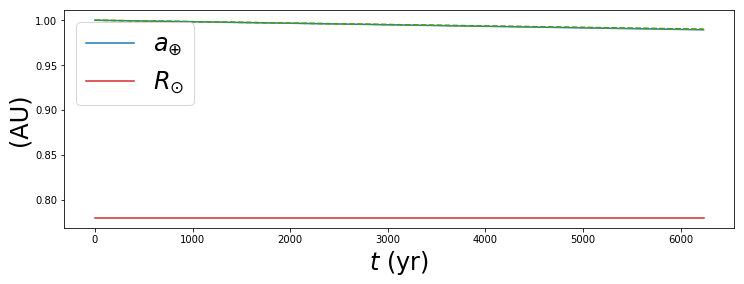

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, pa, label='$a_{\oplus}$')
ax.plot(times, apred, '--')
ax.plot(times, apred2, '--')
ax.plot(times, R0, label='$R_{\odot}$')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('(AU)', fontsize=24)
ax.legend(fontsize=24, loc='best')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


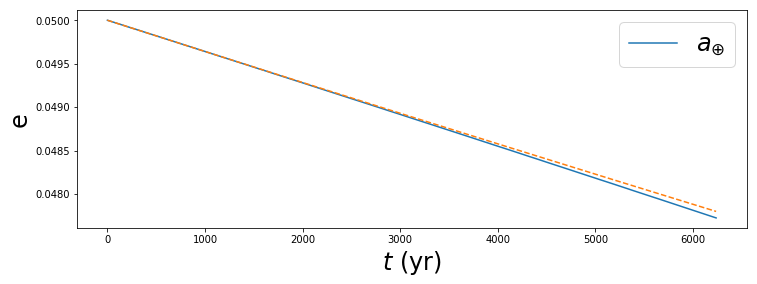

In [49]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times, pe, label='$a_{\oplus}$')
ax.plot(times, epred, '--')
ax.set_xlabel('$t$ (yr)', fontsize=24)
ax.set_ylabel('e', fontsize=24)
ax.legend(fontsize=24, loc='best')

As we can see, the tidal drag due to the post-MS Sun causes Earth's orbit to decay into the tip-RGB photosphere.